<h1>EM</h1>

# 0. 高斯模型

## 极大似然估计

> $l(\theta) = logL(\theta) = \sum _ {i=1}^{N}log N(x_i; \mu, \sigma)$

通过求$l(\theta)$关于$\mu$与$\sigma$的偏导数，令其等于0，可以求得$\mu$与$\sigma$的极大似然估计MLE。

> + $\mu_{MLE} = \frac{1}{N}\sum_{i=1}^{N}x_i$

> + $\sigma_{MLE}^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu_{MLE})^2$

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
from scipy.stats import norm

In [31]:
mu = 1.0
sigma = 0.5
N = 100
samples = np.random.normal(mu, sigma, N)

mu_mle = sum(samples) / N
sigma_mle = math.sqrt(sum(map(lambda x : (x - mu_mle) ** 2, samples)) / N)

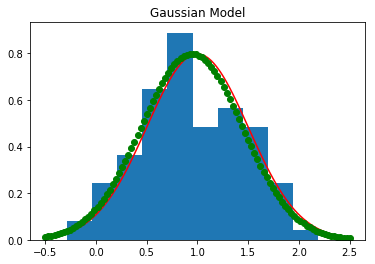

In [33]:
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma), 'r')
plt.plot(x, mlab.normpdf(x, mu_mle, sigma_mle), 'go')
plt.hist(samples, normed = 1)
plt.title("Gaussian Model")
plt.show()

# 1.混合高斯模型

## 1.1 KMeans

对数据集使用高斯分布的极大似然估计，意味着数据集中所有数据都属于同一个类（相同的高斯分布）；分布的参数$\{\mu, \sigma\}$未知，可采用极大似然估计来计算获得。 
> + 分布的参数（均值、方差）未知；

如果对数据集使用KMeans进行聚类，面临的未知比单一分布要多。
> + (a) 每个样本点属于哪个类未知；
> + (b) 每个类的参数（聚类中心）未知；

在有多个未知的情况下，可以选择假定其中大部分已知，在此情况下，获取未知的最优解；根据该最优解迭代递推得到其他未知的最优解。如果该方法能够收敛（局部最优或者全局最优），则得到了在已知数据下，所有未知参数（包括隐含参数）的最优解。

### 形式化
<b>损失函数</b>

> $J = \sum_{n=1}^{N}\sum_{k=1}^{K}r_{nk}||x_n-\mu_k||^2$

$r_{nk}$表示第$n$个样本点是否属于第$k$个类。

> $r_{nk} = 1$, if $k = \arg\min_j ||x_n - \mu_j||^2$; 0 otherwise.

在$r_{nk}$已知的情况下，通过极大似然估计得到$\mu_k$。

> $\mu_k = \frac{\sum{n=1}^{N}r_{nk}x_n}{\sum_{n=1}^{N}r_{nk}}$

从而，$\mu_k$是该类的所有样本的均值。


### KMeans算法流程
> (1) (随机)初始化$K$个中心点

> (2) 迭代进行如下计算，直到满足一定条件（收敛或者达到最大迭代次数）：

> + (a) 依次遍历所有样本点，计算其到每个中心点的距离；将样本划分到距离最小的中心点所标记的类；

> + (b) 根据类标计算每个类的中心点；

算法流程中的步骤（a）、（b）依次解决两个未知。



## 1.2 GMM

假设样本点由多个高斯分布混合叠加组成，需要计算该混合高斯分布的参数$\{\mu_k, \sigma_k\}$。

> $p(x) = \sum_{k=1}^{K}\pi_k N(x;\mu_k,\sigma_k)$

该问题与KMeans一样，同样面临两个未知：

> + (a) 样本点来自每个高斯分布的概率未知；

> + (b) 每个高斯分布的参数（$\mu_k$、$\sigma_k$）以及高斯分布的混合成分$\pi_k$未知；

由于存在隐含参数（a），从而同样无法<b>直接</b>使用极大似然估计。

### 形式化

样本点$n$来自每个高斯分布$k$的概率(softmax):
> + (a) $r_{nk} = \frac{\pi_k N(x_n;\mu_k, \sigma_k)}{\sum_{j=1}^{K}\pi_j N(x_n;\mu_j, \sigma_j)}$


给定隐含参数的情况下，样本的log似然
> + (b) $ln(X|\pi, \mu, \sigma) = \sum_{n=1}^{N}\ln\{\sum_{k=1}^{K}\pi_k N(x_n;\mu_k, \sigma_k)\}$

通过计算log似然关于$\mu_k$的偏导数，并令其等于0，计算得到

> $0 = \sum_{n=1}^{N} \underbrace{ \frac{\pi_k N_k}{\sum_{j=1}^{K}\pi_j N_j} } _{r_{nk}} \frac {(x_n - \mu_k)}{\sigma^2}$

从而，

> $\mu_k = \frac{\sum_{n=1}^{N}r_{nk}x_n}{\sum_{n=1}^{N}r_{nk}}$

另，计算得到

> $\sigma_k^2 = \frac{\sum_{n=1}^{N}r_{nk}(x_n - \mu_k)^2}{\sum_{n=1}^{N}r_{nk}}$

使用Lagrange乘子来计算$\pi$

> $\ln p(X;\mu,\sigma) + \lambda(\sum_{k=1}^{K}\pi_k - 1)$

对$\pi_k$求偏导，得到

> $0 = \sum_{n=1}^{N}\frac{N_k}{\sum_{j=1}^{K}\pi_j N_j} + \lambda$

> $\sum_{k}^{K}\pi_k 0 = \sum_{k}^{K}\pi_k \{ \sum_{n=1}^{N}\frac{N_k}{\sum_{j=1}^{K}\pi_j N_j} + \lambda \} = \sum_{k=1}^{K}\sum_{n=1}^{N} \underbrace{ \frac{\pi_k N_k}{\sum_{j=1}^{K}\pi_j N_j} } _{r_{nk}} + \lambda  $

> $ = \sum_{k=1}^{K}\sum_{n=1}^{N} r_{nk} + \lambda = = \sum_{n=1}^{N}\sum_{k=1}^{K} r_{nk} + \lambda = \sum_{n=1}^{N} + \lambda $ 

所以， $\lambda = -N$。

> $\pi_k 0 = \pi_k \{\sum_{n=1}^{N}\frac{N_k}{\sum_{j=1}^{K}\pi_j N_j} + \lambda\} = \sum_{n=1}^{N}r_{nk}  -N \pi_k$

> $\pi_k = \frac{\sum_{n=1}^{N}r_{nk}}{N}$

与KMeans类似，可以先给定样本点来自每个高斯分布的概率；然后计算每个高斯分布的参数；迭代直到收敛。

### GMM计算流程
> (1) 随机初始化每个高斯分布的参数$\{\mu_k, \sigma_k\}$以及高斯分布混合参数$\pi_k$，计算log似然

> (2) 迭代进行如下步骤，直到收敛：

> + (a) $r_{nk} = \frac{\pi_k N(x_n;\mu_k, \sigma_k)}{\sum_{j=1}^{K}\pi_j N(x_n;\mu_j, \sigma_j)}$

> + (b) $\mu_k = \frac{\sum_{n=1}^{N}r_{nk}x_n}{\sum_{n=1}^{N}r_{nk}}$

> $\sigma_k^2 = \frac{\sum_{n=1}^{N}r_{nk}(x_n - \mu_k)^2}{\sum_{n=1}^{N}r_{nk}}$

> $\pi_k = \frac{\sum_{n=1}^{N}r_{nk}}{N}$

> + (c) 计算log似然 $ln(X|\pi, \mu, \sigma) = \sum_{n=1}^{N}\ln\{\sum_{k=1}^{K}\pi_k N(x_n;\mu_k, \sigma_k)\}$， 判断收敛性。


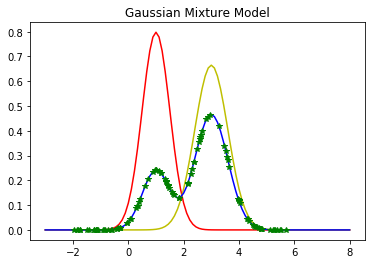

In [15]:
mu1 = 1
sigma1 = 0.5

mu2 = 3 
sigma2 = 0.6

samples = np.random.uniform(-2, 6, 100)
mix = list(map(lambda i : mixture(i, mu1, sigma1, mu2, sigma2), samples))

x = np.linspace(-3, 8, 100)
plt.plot(x, mlab.normpdf(x, mu1, sigma1), 'r')
plt.plot(x, mlab.normpdf(x, mu2, sigma2), 'y')
plt.plot(x, 0.3 * mlab.normpdf(x, mu1, sigma1) + 0.7 * mlab.normpdf(x, mu2, sigma2), 'b')
plt.plot(samples, mix, 'g*')
plt.title('Gaussian Mixture Model')

plt.show()

In [95]:
import numpy as np
import math
from scipy.stats import norm

def get_likelihood(x, pi, mu, sigma):
    return pi * 1. / (math.sqrt(2 * math.pi) * sigma) * math.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


def get_log_likelihood(samples, pis, mus, sigmas):
    log_likelihood = 0

    for x in samples:
        likelihood = 0
        for i in range(len(pis)):
            likelihood += get_likelihood(x, pis[i], mus[i], sigmas[i])
        if abs(likelihood) < 1e-6:
            likelihood = 1e-6
        log_likelihood += math.log(likelihood)
    return log_likelihood

def mixture(x, mu1, sigma1, mu2, sigma2):
    return 0.3 * norm(mu1, sigma1).pdf(x) + 0.7 * norm(mu2, sigma2).pdf(x)


mu1 = 1
sigma1 = 0.5

mu2 = 4
sigma2 = 0.6

num = 500
a = np.random.normal(mu1, sigma1, num)
b = np.random.normal(mu2, sigma2, num)
samples = 0.3 * a + 0.7 * b


# GMM EM

# Initialization
N = len(samples)
K = 2

print(sum(samples) / N)
mus = [0, 5]
sigmas = [0.5, 0.5]
pis = [0.2, 0.8]

likelihood = get_log_likelihood(samples, pis, mus, sigmas)
print(likelihood)

# EM
max_iteration = 10000
min_delta = 1e-4

# r_nk
r = np.zeros((N, K))
new_mus = np.zeros(K)
new_sigmas = np.zeros(K)
new_pis = np.zeros(K)

for i in range(max_iteration):
    # E-step, compute r_nk
    for n in range(N):
        x = samples[n]

        pdfs = np.zeros(K)

        for k in range(K):
            pdfs[k] = get_likelihood(x, pis[k], mus[k], sigmas[k])

        constant = sum(pdfs)

        for k in range(K):
            r[n, k] = pdfs[k] / constant

    # M-step, compute mu_k, sigma_k, pi_k

    for k in range(K):
        denominator = sum(r[:, k])

        if abs(denominator) < 1e-6:
            denominator = 1e-6

        new_mus[k] = sum(map(lambda x: x[0] * x[1], zip(r[:, k], samples))) / denominator
        new_sigmas[k] = math.sqrt(sum(map(lambda x: x[0] * ((x[1] - new_mus[k]) ** 2), zip(r[:, k], samples))) / denominator)
        new_pis[k] = denominator / N

    new_likeihood = get_log_likelihood(samples, new_pis, new_mus, new_sigmas)
    delta = new_likeihood - likelihood

    if i % 100 == 0:
        print(i, delta, new_mus, new_sigmas, new_pis)

    if delta < min_delta:
        print(i, delta, new_mus, new_sigmas, new_pis)
        break

    pis, mus, sigmas = new_pis, new_mus, new_sigmas
    likelihood = new_likeihood


print(mus)
print(sigmas)
print(pis)

3.07881312707
-4161.660982026794
0 3849.4553112714134 [ 2.34595157  3.15899112] [ 0.16682483  0.38905555] [ 0.09861512  0.90138488]
100 0.0034669071916937355 [ 2.67550832  3.15071505] [ 0.26866348  0.43150199] [ 0.15130662  0.84869338]
200 0.001297995729316881 [ 2.69725753  3.18591175] [ 0.29013365  0.42135424] [ 0.21917056  0.78082944]
300 0.0007940590024304583 [ 2.71395085  3.21420066] [ 0.30039887  0.41252644] [ 0.27063985  0.72936015]
400 0.0005927411189077247 [ 2.72884889  3.23947023] [ 0.30681696  0.4044251 ] [ 0.31463061  0.68536939]
500 0.00048292498019009145 [ 2.74288404  3.26302955] [ 0.31152156  0.39680093] [ 0.35416324  0.64583676]
600 0.0004079251492612457 [ 2.75634192  3.28533177] [ 0.31535969  0.38957698] [ 0.3904019  0.6095981]
700 0.00034818908068245946 [ 2.76926075  3.30648298] [ 0.3187262   0.38275212] [ 0.42379083  0.57620917]
800 0.00029661322247420685 [ 2.7815818   3.32645335] [ 0.32181507  0.37635019] [ 0.45449285  0.54550715]
900 0.00025084497605121214 [ 2.79322